# Reddit API

In [5]:
from soc_api import Reddit
import pandas as pd
import json

pd.set_option('display.max_columns', None)

with open('secrets.json') as user_file:
  secrets = json.loads(user_file.read())

In [9]:
client_id = secrets['reddit']['key']
client_secret = secrets['reddit']['secret']

red = Reddit(client_id,client_secret)

In [10]:
subreddit = 'MLS'
post_ids = [p for p in red.get_submissions(subreddit, time_filter='week', limit=1000)]
print(len(post_ids))
post_ids[0:3]

194


['13c6tg3', '13bncl8', '13b5r7a']

In [11]:
thread_urls = ['https://www.reddit.com/r/MLS/comments/138w5p7/lizzy_becherano_exclusive_sources_confirm_a_new/',
              'https://www.reddit.com/r/MLS/comments/138ts1p/tannenwald_the_full_transcript_of_the_exchange/']

coms = red.process_submissions(post_ids[:3])

100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


In [15]:
dates = [c['created_date'] for c in coms]

min(dates), max(dates)

(datetime.datetime(2023, 5, 7, 22, 53, 1),
 datetime.datetime(2023, 5, 9, 23, 14, 51))

In [2]:
# filename = '{}_{}_{}.csv'.format(subreddit,min(dates).strftime('%Y-%m-%d'), max(dates).strftime('%Y-%m-%d'))
# red.write_csv(coms,filename)
coms_df = pd.read_csv('MLS_2023-04-30_2023-05-07.csv')

In [18]:
print(coms_df.shape)
coms_df.head()

(9715, 25)


,subreddit,submission_text,created_utc,controversiality,submission_id,score,likes,distinguished,downs,title,author,upvote_ratio,url_domain,permalink,retrieve_time,created_date,parent_id,type,gilded,url,body,num_reports,total_awards_received,id,score_percent
0,MLS,NaN,1.682946e+09,NaN,134ls7m,1109,NaN,NaN,NaN,[meme] It would end the pain,Fraganade,0.98,i.imgur.com,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 12:57:25,NaN,submission,NaN,https://i.imgur.com/duojFS6.jpg,NaN,NaN,NaN,134ls7m,0.010596
1,MLS,NaN,1.682949e+09,0.0,134ls7m,111,NaN,NaN,0.0,NaN,formerly_LTRLLTRL,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 13:53:30,t3_134ls7m,comment,0.0,NaN,The fact that this is currently the highest ra...,NaN,0.0,jifj98o,0.001061
2,MLS,NaN,1.682949e+09,0.0,134ls7m,62,NaN,NaN,0.0,NaN,Cad_Monkey_Mafia,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 13:57:14,t3_134ls7m,comment,0.0,NaN,In search of a vehicle to run you over and end...,NaN,0.0,jifjqzq,0.000592
3,MLS,NaN,1.682950e+09,0.0,134ls7m,23,NaN,NaN,0.0,NaN,lookitskelvin,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 14:01:56,t3_134ls7m,comment,0.0,NaN,This is going to be a legendary reused meme,NaN,0.0,jifkd79,0.000220
4,MLS,NaN,1.682950e+09,0.0,134ls7m,30,NaN,NaN,0.0,NaN,Sneaky_Ben,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 14:07:01,t3_134ls7m,comment,0.0,NaN,Well you certainly picked the right country fo...,NaN,0.0,jifl18k,0.000287


In [20]:
coms_df.type.value_counts()

type
comment_reply    5971
comment          3564
submission        180
Name: count, dtype: int64

In [21]:
coms_df.url_domain.value_counts()

url_domain
i.redd.it                         40
twitter.com                       33
www.reddit.com                    24
www.mlssoccer.com                 14
v.redd.it                         10
i.imgur.com                        6
theathletic.com                    4
youtu.be                           4
www.inquirer.com                   3
www.espn.com                       3
www.youtube.com                    2
www.goal.com                       2
imgur.com                          2
www.americansocceranalysis.com     2
www.concacaf.com                   2
www.newyorkredbulls.com            1
itscalledsoccer.substack.com       1
www.sandiegouniontribune.com       1
streamin.one                       1
www.fcdallas.com                   1
www.backheeled.com                 1
www.burnleyfootballclub.com        1
www.intermiamicf.com               1
austin.towers.net                  1
www.espnfc.com                     1
www.protagonistsoccer.com          1
www.theblazingmusket.com   

<Axes: >

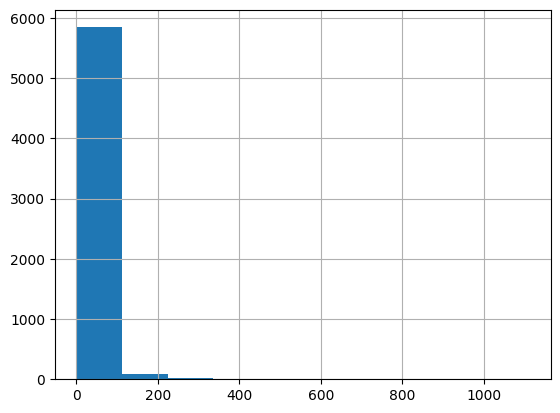

In [23]:
coms_df[coms_df.score>2].score.hist()

array([[<Axes: title={'center': 'comment'}>,
        <Axes: title={'center': 'comment_reply'}>],
       [<Axes: title={'center': 'submission'}>, <Axes: >]], dtype=object)

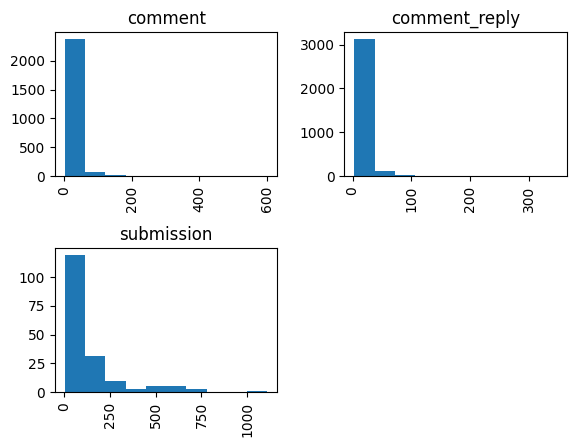

In [24]:
coms_df[coms_df.score>2].score.hist(by=coms_df['type'])

array([<Axes: title={'center': 'comment'}, xlabel='created_date'>,
       <Axes: title={'center': 'comment_reply'}, xlabel='created_date'>,
       <Axes: title={'center': 'submission'}, xlabel='created_date'>],
      dtype=object)

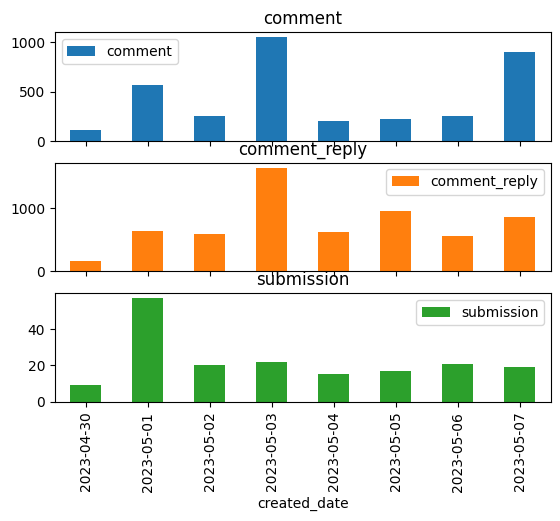

In [25]:
coms_df \
    .groupby([pd.to_datetime(coms_df.created_date).dt.date,'type']).count()['id'].reset_index() \
    .pivot(index='created_date', columns='type', values='id') \
    .plot.bar(subplots=True)

array([<Axes: title={'center': 'comment'}, xlabel='created_date'>,
       <Axes: title={'center': 'comment_reply'}, xlabel='created_date'>,
       <Axes: title={'center': 'submission'}, xlabel='created_date'>],
      dtype=object)

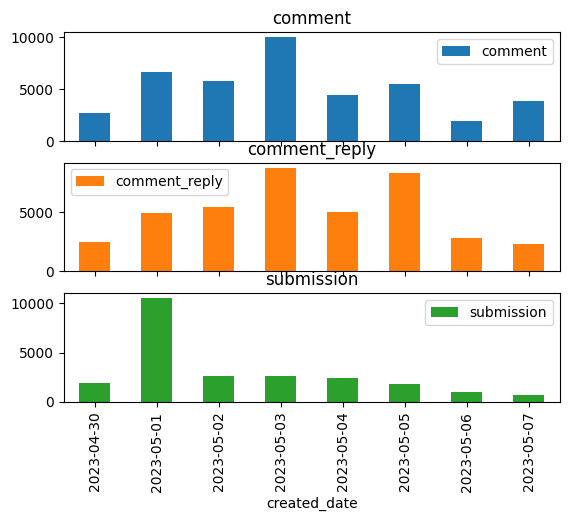

In [26]:
coms_df \
    .groupby([pd.to_datetime(coms_df.created_date).dt.date,'type']).sum()['score'].reset_index() \
    .pivot(index='created_date', columns='type', values='score') \
    .plot.bar(subplots=True)

In [27]:
coms_df[coms_df.controversiality !=0].head()

,subreddit,submission_text,created_utc,controversiality,submission_id,score,likes,distinguished,downs,title,author,upvote_ratio,url_domain,permalink,retrieve_time,created_date,parent_id,type,gilded,url,body,num_reports,total_awards_received,id,score_percent
0,MLS,NaN,1.682946e+09,NaN,134ls7m,1109,NaN,NaN,NaN,[meme] It would end the pain,Fraganade,0.98,i.imgur.com,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 12:57:25,NaN,submission,NaN,https://i.imgur.com/duojFS6.jpg,NaN,NaN,NaN,134ls7m,0.010596
38,MLS,NaN,1.682962e+09,NaN,134u5dj,760,NaN,NaN,NaN,[MEME] The regular season's all that matters.....,MkPapadopoulos,0.98,i.redd.it,/r/MLS/comments/134u5dj/meme_the_regular_seaso...,2023-05-06 23:17:31,2023-05-01 17:22:37,NaN,submission,NaN,https://i.redd.it/1nnrsv0g79xa1.jpg,NaN,NaN,NaN,134u5dj,0.007262
75,MLS,NaN,1.682968e+09,1.0,134u5dj,2,NaN,NaN,0.0,NaN,Scratchbuttdontsniff,NaN,NaN,/r/MLS/comments/134u5dj/meme_the_regular_seaso...,2023-05-06 23:17:31,2023-05-01 19:01:33,t1_jigsnra,comment_reply,0.0,NaN,Not for me... I am Chiefs fan... But 2019 does...,NaN,0.0,jigsy4k,0.000019
83,MLS,NaN,1.682830e+09,NaN,133fwvu,755,NaN,NaN,NaN,Portland Thorns [3] - 3 Angel City - Bella Bix...,TheMonkeyPrince,0.96,v.redd.it,/r/MLS/comments/133fwvu/portland_thorns_3_3_an...,2023-05-06 23:17:31,2023-04-30 04:39:40,NaN,submission,NaN,https://v.redd.it/mhsecsiraywa1,NaN,NaN,NaN,133fwvu,0.007214
107,MLS,NaN,1.682873e+09,1.0,133fwvu,-2,NaN,NaN,0.0,NaN,outdoorman92,NaN,NaN,/r/MLS/comments/133fwvu/portland_thorns_3_3_an...,2023-05-06 23:17:31,2023-04-30 16:35:44,t3_133fwvu,comment,0.0,NaN,Why is the Portland keeper on that end of the ...,NaN,0.0,jibmk2j,-0.000019


In [28]:
coms_df.groupby('retrieve_time').count().head()['id']


retrieve_time
2023-05-06 23:17:30     38
2023-05-06 23:17:31    201
2023-05-06 23:17:32    143
2023-05-06 23:17:33    142
2023-05-06 23:17:34    522
Name: id, dtype: int64

# LLM Model API - Huggingface

  - https://huggingface.co/docs/api-inference/quicktour

In [ ]:
def ask_hf_llm(q,model,token):
    '''
    Query a hugging face hosted llm model.
    '''
    import requests

    API_URL = "https://api-inference.huggingface.co/models/{}".format(model)
    headers = {"Authorization": "Bearer {}".format(token)}

    def query(payload):
        response = requests.post(API_URL, headers=headers, json=payload)
        return response.json()

    output = query({
        "inputs": q,
    })
    return output

q = 'What are you?'
for m in ["databricks/dolly-v2-3b",
          "google/flan-t5-large",
          "facebook/blenderbot-400M-distill", #tuned for conversations
          "bigscience/bloomz",
          "bigscience/bloom",
          "gpt-3.5-turbo", 
          "mosaicml/mpt-1b-redpajama-200b-dolly", # decoder transformer
          "mosaicml/mpt-7b", # released recently
          "mosaicml/mpt-7b-chat",
          "CarperAI/stable-vicuna-13b-delta" # allegedly best open-source LLM
         ]:
    print(m,': ', ask_hf_llm(q,m,secrets['huggingface']['key']),'\n')
    

```
databricks/dolly-v2-3b :  [{'generated_text': 'What are you?\n\nI am a data scientist and machine learning enthusiast. I have been'}] 

google/flan-t5-large :  [{'generated_text': 'a sailor'}] 

facebook/blenderbot-400M-distill :  {'generated_text': ' I am a student. I am studying to be a nurse. What do you do?', 'conversation': {'generated_responses': [' I am a student. I am studying to be a nurse. What do you do?'], 'past_user_inputs': ['What are you?']}} 

bigscience/bloomz :  [{'generated_text': 'What are you? a film'}] 

bigscience/bloom :  [{'generated_text': 'What are you?"\n\n"I\'m a man," said the stranger, "and I want to see the king.'}] 

mosaicml/mpt-1b-redpajama-200b-dolly :  {'error': 'Task not found for this model'} 

gpt-3.5-turbo :  {'error': 'Model gpt-3.5-turbo does not exist'} 

mosaicml/mpt-7b :  {'error': 'The model mosaicml/mpt-7b is too large to be loaded automatically (13GB > 10GB). For commercial use please use PRO spaces (https://huggingface.co/spaces) or Inference Endpoints (https://huggingface.co/inference-endpoints).'} 

mosaicml/mpt-7b-chat :  {'error': 'The model mosaicml/mpt-7b-chat is too large to be loaded automatically (13GB > 10GB). For commercial use please use PRO spaces (https://huggingface.co/spaces) or Inference Endpoints (https://huggingface.co/inference-endpoints).'} 

CarperAI/stable-vicuna-13b-delta :  {'error': 'The model CarperAI/stable-vicuna-13b-delta is too large to be loaded automatically (26GB > 10GB). For commercial use please use PRO spaces (https://huggingface.co/spaces) or Inference Endpoints (https://huggingface.co/inference-endpoints).'} 

```

# LLM Model API - Langchain

For huggingface hosted models only supports [`text2text generation`](https://huggingface.co/models?pipeline_tag=text2text-generation&sort=downloads) and [`textgeneration`](https://huggingface.co/models?pipeline_tag=text-generation&sort=downloads) types.

In [4]:
import os 
 
os.environ["HUGGINGFACEHUB_API_TOKEN"] = secrets['huggingface']['key']

os.environ["OPENAI_API_KEY"] = secrets['openai']['key']

In [8]:
from langchain import PromptTemplate, HuggingFaceHub, LLMChain
from langchain.llms import HuggingFacePipeline
from langchain.chat_models import ChatOpenAI
import torch
from transformers import pipeline

# load a few models
model_params = {"temperature":0, "max_length":64}

# generate_text = pipeline(model="databricks/dolly-v2-3b", torch_dtype=torch.bfloat16,
#                          trust_remote_code=True, device_map="auto", return_full_text=True)
# llm_dolly_local = HuggingFacePipeline(pipeline=generate_text) # locally saved dolly pipeline
llm_dolly = HuggingFaceHub(repo_id="databricks/dolly-v2-3b", model_kwargs=model_params) # hf hosted llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo") # openai hosted llm
llm_flan = HuggingFaceHub(repo_id="google/flan-t5-large", model_kwargs=model_params) # hf hosted llm
llm_bloom = HuggingFaceHub(repo_id="bigscience/bloomz") # hf hosted llm

# define the prompt
template = """ Question: {question}"""
prompt = PromptTemplate(template=template, input_variables=["question"])

# create chains
llm_dolly_chain = LLMChain(prompt=prompt,llm=llm_dolly)
llm_chain = LLMChain(prompt=prompt, llm=llm)
llm_chain_flan = LLMChain(prompt=prompt, llm=llm_flan)
llm_chain_bloom = LLMChain(prompt=prompt, llm=llm_bloom)

# run
question = "Who is the best soccer player in history?"

print(question,'\n')
# print('# Dolly:\n',llm_dolly_chain.run(question)) # times out
print('\n# gpt-3.5-turbo:\n',llm_chain.run(question))
print('\n# Flan:\n',llm_chain_flan.run(question))
print('\n# Bloom:\n',llm_chain_bloom.run(question))

Who is the best soccer player in history? 


# gpt-3.5-turbo:
 As an AI language model, I do not have personal opinions or beliefs. However, there is no definitive answer to who the best soccer player in history is, as it is subjective and depends on individual opinions and criteria. Some of the most commonly mentioned names in discussions about the best soccer player ever include Pele, Diego Maradona, Lionel Messi, Cristiano Ronaldo, Johan Cruyff, and many others.

# Flan:
 gertrude bell

# Bloom:
  Pele


# Pandas DataFrame Agent

In [11]:
from langchain.agents import create_pandas_dataframe_agent

agent = create_pandas_dataframe_agent(llm, coms_df, verbose=True)

agent.run("how many rows and columns are there?")



> Entering new AgentExecutor chain...
Thought: We can use the `shape` attribute of the dataframe to get the number of rows and columns.
Action: python_repl_ast
Action Input: df.shape
Observation: (9715, 24)
Thought:The dataframe has 9715 rows and 24 columns.
Final Answer: There are 9715 rows and 24 columns.

> Finished chain.


'There are 9715 rows and 24 columns.'

In [ ]:
agent.run("""Use python_repl_ast tool. Create a TFIDF matrix using the body column and cluster into topics. Convert body column to lowercase.""")

In [119]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
df = coms_df

# Remove any rows with NaN values in the body column
df.dropna(subset=['body'], inplace=True)

# Convert text to lowercase
df['body'] = df['body'].str.lower()

# Remove punctuation
df['body'] = df['body'].str.replace('[^\w\s]','')

# Remove numbers
df['body'] = df['body'].str.replace('\d+', '')

# Remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['body'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Create TFIDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df['body'])

# Cluster into topics
kmeans = KMeans(n_clusters=5).fit(tfidf)

C:\Users\twnba\Anaconda3\envs\llm\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [123]:
pd.Series(kmeans.labels_).value_counts()

1    6332
4    1745
2     628
3     450
0     380
Name: count, dtype: int64

# Custom Dataframe Agent

# Topic Modelling (Clustering)


In [5]:
coms_df['content'] = coms_df.title.fillna('') + coms_df.submission_text.fillna('') + coms_df.body.fillna('')

# Embeddings

In [8]:
coms_df.head()

,subreddit,submission_text,created_utc,controversiality,submission_id,score,likes,distinguished,downs,title,author,upvote_ratio,url_domain,permalink,retrieve_time,created_date,parent_id,type,gilded,url,body,num_reports,total_awards_received,id,content
0,MLS,NaN,1.682946e+09,NaN,134ls7m,1109,NaN,NaN,NaN,[meme] It would end the pain,Fraganade,0.98,i.imgur.com,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 12:57:25,NaN,submission,NaN,https://i.imgur.com/duojFS6.jpg,NaN,NaN,NaN,134ls7m,[meme] It would end the pain
1,MLS,NaN,1.682949e+09,0.0,134ls7m,111,NaN,NaN,0.0,NaN,formerly_LTRLLTRL,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 13:53:30,t3_134ls7m,comment,0.0,NaN,The fact that this is currently the highest ra...,NaN,0.0,jifj98o,The fact that this is currently the highest ra...
2,MLS,NaN,1.682949e+09,0.0,134ls7m,62,NaN,NaN,0.0,NaN,Cad_Monkey_Mafia,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 13:57:14,t3_134ls7m,comment,0.0,NaN,In search of a vehicle to run you over and end...,NaN,0.0,jifjqzq,In search of a vehicle to run you over and end...
3,MLS,NaN,1.682950e+09,0.0,134ls7m,23,NaN,NaN,0.0,NaN,lookitskelvin,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 14:01:56,t3_134ls7m,comment,0.0,NaN,This is going to be a legendary reused meme,NaN,0.0,jifkd79,This is going to be a legendary reused meme
4,MLS,NaN,1.682950e+09,0.0,134ls7m,30,NaN,NaN,0.0,NaN,Sneaky_Ben,NaN,NaN,/r/MLS/comments/134ls7m/meme_it_would_end_the_...,2023-05-06 23:17:30,2023-05-01 14:07:01,t3_134ls7m,comment,0.0,NaN,Well you certainly picked the right country fo...,NaN,0.0,jifl18k,Well you certainly picked the right country fo...


In [10]:
df = coms_df[coms_df.type == 'comment']
df.shape

(3564, 25)

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.chains.summarize import load_summarize_chain

hf_embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

C:\Users\kkhitalishvili\AppData\Local\miniconda3\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df_embed = hf_embeddings.embed_documents(df.content)

In [14]:
import numpy as np
np.array(df_embed)

array([[-0.07812253,  0.04172057,  0.02518834, ...,  0.03464252,
         0.07967573,  0.09582146],
       [ 0.04025031, -0.00986579,  0.08373296, ..., -0.01209686,
        -0.00319501,  0.06018887],
       [-0.13586168,  0.05229077,  0.0317517 , ..., -0.03036363,
         0.0198387 , -0.01816775],
       ...,
       [-0.05155369, -0.01708416,  0.05289747, ..., -0.0440793 ,
         0.03768054,  0.05834622],
       [ 0.03237549,  0.00902035, -0.00630007, ..., -0.0287155 ,
        -0.04295462,  0.00366764],
       [-0.07387499, -0.02412497,  0.05087962, ..., -0.08212914,
         0.04299294,  0.03229758]])

## Vectorstore

In [111]:
coms_df['source'] = coms_df.id

loader = DataFrameLoader(coms_df, page_content_column="content")
docs = loader.load()
text_split = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 0)
text = text_split.split_documents(docs)

In [112]:
text[0]

Document(page_content='[meme] It would end the pain', metadata={'subreddit': 'MLS', 'submission_text': nan, 'created_utc': 1682945845.0, 'controversiality': nan, 'submission_id': '134ls7m', 'score': 1109, 'likes': nan, 'distinguished': nan, 'downs': nan, 'title': '[meme] It would end the pain', 'author': 'Fraganade', 'upvote_ratio': 0.98, 'url_domain': 'i.imgur.com', 'permalink': '/r/MLS/comments/134ls7m/meme_it_would_end_the_pain/', 'retrieve_time': '2023-05-06 23:17:30', 'created_date': '2023-05-01 12:57:25', 'parent_id': nan, 'type': 'submission', 'gilded': nan, 'url': 'https://i.imgur.com/duojFS6.jpg', 'body': nan, 'num_reports': nan, 'total_awards_received': nan, 'id': '134ls7m', 'source': '134ls7m'})

In [113]:
len(text)

9845

In [114]:
coms_df.shape

(9715, 26)

In [115]:
# pass the text and embeddings to FAISS
vectorstore = FAISS.from_documents(text, hf_embeddings)

In [ ]:
# vectorstore.save_local('faiis_db')
vectorstore.write_index('faiss_db.index')

In [ ]:
from pprint import pprint
query = "Philadelphia?"
documents = vectorstore.similarity_search(query)
pprint(documents)

In [ ]:
len(documents)

In [ ]:
question = 'What are the main news?'
my_chain = load_qa_with_sources_chain(llm, chain_type="refine")
my_chain({"input_documents": documents, "question": question})

In [ ]:
prompt_template = """Write a concise summary of the following:


{text}


CONCISE SUMMARY:"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])
chain = load_summarize_chain(llm_dolly, chain_type="stuff", prompt=PROMPT)
chain.run(text)

In [133]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=vectorstore.as_retriever())
qa.run('Can you give me insisghts?')

"I'm sorry, I cannot provide insights as your question is too broad and lacks context. Please provide more specific information or ask a more specific question."

<Axes: >

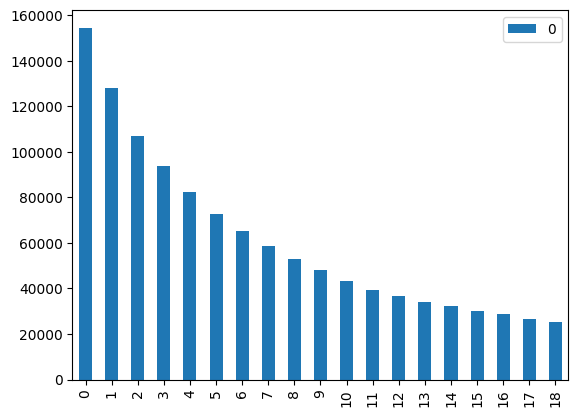

In [31]:
# number of comments by score greater than i
pd.DataFrame([len(' '.join(coms_df[coms_df.score>i].content).split(' ')) for i in range(1,20)]).plot.bar()

In [47]:
[len(' '.join(coms_df[coms_df.score>i].content).split(' ')) for i in range(1,20)]

[154660,
 128087,
 107032,
 93796,
 82218,
 72851,
 65226,
 58603,
 52779,
 48130,
 43297,
 39169,
 36641,
 34075,
 32321,
 30027,
 28587,
 26678,
 25336]

## Clustering

In [87]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import faiss
import numpy as np

def auto_cluster(X, n=range(2,11), normalize=False):
    n_range = n
    wcss = []
    silhouette_scores = []
    labels = []
    
    if normalize:
        X = normalize(X)
    X_scatter = X.copy()
    
    if X_scatter.shape[1] >2:
        pca = PCA(n_components=2)
        X_scatter = pca.fit_transform(X_scatter)
        
    for i in n_range:
        kmeans = KMeans(n_clusters=i,  max_iter=300, n_init=10, random_state=0)
        # kmeans = FaissKMeans(n_clusters=i, max_iter=300, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        labels.append(kmeans.labels_)
    
    best_n_index = max(enumerate(silhouette_scores),key=lambda x: x[1])[0]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))

    color = 'tab:red'
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS', color=color)
    ax1.plot(n_range, wcss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1_twin = ax1.twinx()

    color = 'tab:blue'
    ax1_twin.set_ylabel('Silhouette score', color=color)
    ax1_twin.plot(n_range, silhouette_scores, color=color)
    ax1_twin.tick_params(axis='y', labelcolor=color)

    # Second plot
    ax2.scatter(X_scatter[:,0], X_scatter[:,1], c=labels[best_n_index])
    ax2.set_xlabel('PCA1')
    ax2.set_ylabel('PCA2')

    fig.suptitle('{} Clusters'.format(best_n_index+2), fontsize=20)
    fig.tight_layout()

    plt.show()
    
class FaissKMeans:
    # https://github.com/facebookresearch/faiss/issues/2492
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.labels_= None
    def fit(self, data_dict):
        # X = np.array(data_dict['embeddings']).astype('float32')
        X = data_dict.astype('float32')
        faiss.normalize_L2(X)
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                 k=self.n_clusters,
                                 niter=self.max_iter,
                                 nredo=self.n_init,
                                 gpu = True,
                                 verbose = True)
                                 #index = quantizer)
        self.kmeans.train(X)
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
        self.labels_ = self.predict(X)
  
    def predict(self, data_dict):
        X = data_dict.astype('float32')
        labels = [float(element) for element in self.kmeans.index.search(X, 1)[1]]
        return labels
  

<Axes: title={'center': 'Explained Variance Ratio by PC'}>

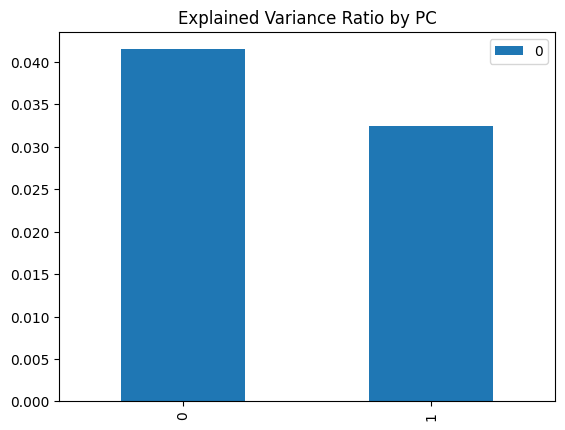

In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pc = pca.fit_transform(StandardScaler().fit_transform(df_embed))
pd.DataFrame(pca.explained_variance_ratio_).plot.bar(title='Explained Variance Ratio by PC')

In [60]:
np.array(df_embed).shape

(3564, 384)

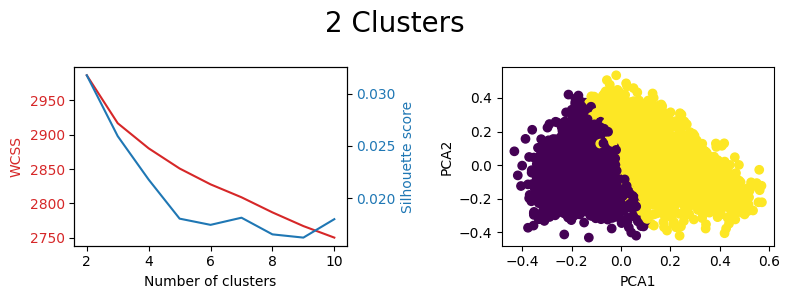

In [90]:

auto_cluster(normalize(np.array(df_embed)))

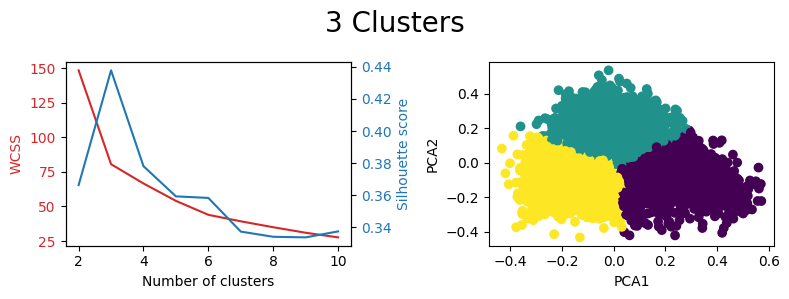

In [92]:
auto_cluster(pc)

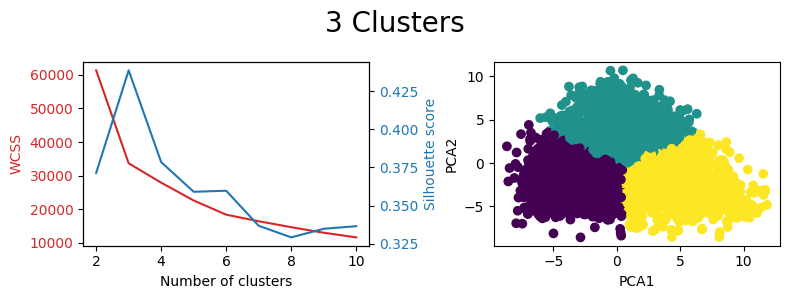

In [96]:
auto_cluster(pc)

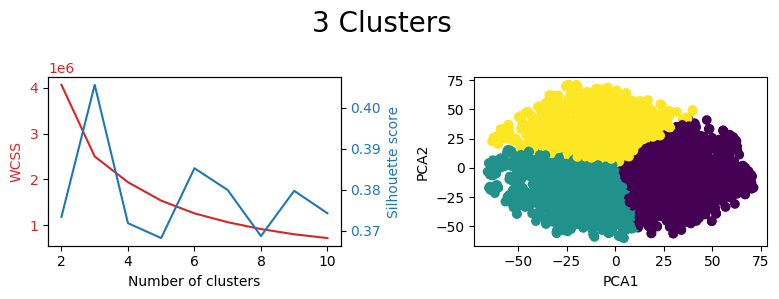

In [97]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
ts = tsne.fit_transform(np.array(df_embed))

auto_cluster(ts)

# Summarization

In [40]:
from langchain.docstore.document import Document

doc= Document(page_content=' '.join(coms_df[coms_df.score>20].content))
text_split = RecursiveCharacterTextSplitter(chunk_size = 3000, chunk_overlap = 0)
text = text_split.split_documents([doc])
len(text)

51

In [46]:
chain = load_summarize_chain(llm, chain_type="map_reduce")
chain.run(text)

'The discussion thread and article both cover a range of topics related to soccer, including team performances, ownership models, and tournaments. Users and the author express opinions and criticisms about various aspects of the sport and its organizations, including concerns about stadium choices and player conduct.'

# Notes

  - https://github.com/microsoft/guidance
  - https://medium.com/@marcotcr/exploring-chatgpt-vs-open-source-models-on-slightly-harder-tasks-aa0395c31610
  - https://maartengr.github.io/BERTopic/index.html
  - [LDA vs NMF vs BERTopic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC912093)